In [1]:
!pip install python-box timm pytorch-lightning grad-cam ttach

     |████████████████████████████████| 376 kB 1.2 MB/s 
     |████████████████████████████████| 1.8 MB 18.5 MB/s 
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - done
  Created wheel for grad-cam: filename=grad_cam-1.3.5-py3-none-any.whl size=22419 sha256=c27ede0755376a5ea4a6dac1bbaefb4708dea9f861708860d4fd8288641b6889
  Stored in directory: /root/.cache/pip/wheels/89/d1/a6/41cb46183c56fe9e78ba80781ca35c3bc2728406b694fb7a13
Successfully built grad-cam


In [2]:
import os
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import glob

import torch
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule
from pytorch_lightning import callbacks
from pytorch_lightning.loggers import TensorBoardLogger
#from pytorch_lightning.callbacks.progress.tqdm_progress import TQDMProgressBar

from box import Box
from timm import create_model
from sklearn.model_selection import StratifiedKFold

In [3]:
config = {'epoch': 20,
          'n_splits': 10,
          'Image_size': 224,
          'root': '../input/petfinder-pawpularity-score',
          'img_root': '../input/petfinder2-cropped-dataset/crop',
          'train_root': '../input/petfinder-pawpularity-score/train',
          'test_root': '../input/petfinder-pawpularity-score/test',
          'checkpoints_root': '../input/my-petfinder-test',
          'lr': 1e-5,
          'train_loader': {
                'batch_size': 64,
                'shuffle': True,
                'num_workers': 2,
                'drop_last': True
            },
          'val_loader': {
              'batch_size': 64,
              'shuffle': False,
              'num_workers': 2,
              'drop_last': False
            },
          'test_loader': {
              'batch_size': 64,
              'shuffle': False,
              'num_workers': 2,
            },
          'model': {
              'name': 'swin_tiny_patch4_window7_224',
              #'name': 'swin_large_patch4_window7_224',
              'output_dim': 1
          },
          'optimizer': {
              'name': 'optim.AdamW',
              'params': {
                  'lr': 1e-5,
                  'amsgrad': True,
                  #'weight_decay': 1e-6,
              }
          },
          'loss': 'torch.nn.BCEWithLogitsLoss',
          'trainer': {
              'gpus': 1,
              'accumulate_grad_batches': 1,
              'fast_dev_run': False,
              'num_sanity_val_steps': 0,
              'resume_from_checkpoint': None,
              'progress_bar_refresh_rate': 1
          },
          'scheduler': {
              'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
              'params': {
                  'T_0': 25,
                  'eta_min': 1e-6,
                  'T_mult': 1                  
              }
          }
        }

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

config = Box(config)

df_train = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
df_test = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')

meta_features = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
                 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

In [4]:
PET_MEAN = [0.5184, 0.4836, 0.4459]
PET_STD = [0.229, 0.224, 0.225]

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [5]:
def transformations():
    default_transforms = {
        'train': T.Compose([
                            #T.Resize([config.Image_size, config.Image_size]),
                            T.RandomHorizontalFlip(),
                            T.RandomVerticalFlip(),
                            #T.RandomPerspective(p=0.7),
                            T.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                            T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                            #T.ToTensor(),
                            T.ConvertImageDtype(torch.float),
                            T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
                            ]),

        'val': T.Compose([
                          #T.Resize([config.Image_size, config.Image_size]),
                          #T.ToTensor(),
                          T.ConvertImageDtype(torch.float),
                          T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
                          ]),
        'test': T.Compose([
                           #T.Resize([config.Image_size, config.Image_size]),
                           #T.ToTensor(),
                           T.ConvertImageDtype(torch.float),
                           T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
                          ])
        }
    return default_transforms

# Dataset

In [6]:
class PetDataset(Dataset):
    def __init__(self, root, dataframe, meta_features=meta_features, transforms=None):
        self.root = root
        self.df = dataframe
        self.y = None
        self.meta_data = dataframe[meta_features].values
        self.transforms = transforms
        if 'Pawpularity' in dataframe.keys():
            self.y = dataframe['Pawpularity'].values

    def __len__(self):
            return self.df.shape[0]

    def __getitem__(self, idx):
        img_names = self.df['Id'].apply(lambda x: x + '.jpg').values
        img_path = os.path.join(self.root, img_names[idx])
        image = Image.open(img_path).convert('RGB')
        features = self.meta_data[idx,:]
        features = torch.tensor(features, dtype=torch.float)
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        if self.y is not None:
            label = self.y[idx]
            return image, features, label

        return image, features

class PetDataModule(LightningDataModule):
    def __init__(self, train_dataframe, val_dataframe, test_dataframe, cfg):
        super().__init__()
        self.train_df = train_dataframe
        #self.train_labels = train_labels 
        self.val_df = val_dataframe 
        #self.val_labels = val_labels 
        self.test_df = test_dataframe
        self.cfg = cfg

    def __create_dataset(self, mode):
        if mode == 'train':
            return PetDataset(
                              self.cfg.img_root, 
                              self.train_df, 
                              meta_features,
                              transforms=T.Compose([
                                                   T.Resize([config.Image_size, config.Image_size]),
                                                   T.ToTensor(),
                                                  ])
                              )
        elif mode == 'val':
            return PetDataset(
                              self.cfg.img_root,
                              self.val_df,
                              meta_features,
                              transforms=T.Compose([
                                                   T.Resize([config.Image_size, config.Image_size]),
                                                   T.ToTensor(),
                                                  ])
                              )
        elif mode == 'test':
            return PetDataset(
                              self.cfg.img_root,
                              self.test_df,
                              meta_features,
                              transforms=T.Compose([
                                                   T.Resize([config.Image_size, config.Image_size]),
                                                   T.ToTensor(),
                                                  ])
                              )


    def train_dataloader(self):
        dataset = self.__create_dataset('train')
        return DataLoader(dataset, 
                          **self.cfg.train_loader)
        
    def val_dataloader(self):
        dataset = self.__create_dataset('val')
        return DataLoader(dataset,
                          **self.cfg.val_loader)
        
    def test_dataloader(self):
        dataset = self.__create_dataset('test')
        return DataLoader(dataset, **self.cfg.test_loader)


## Visualization

In [7]:
data = PetDataModule(df_train, df_train, None,config)
samples = data.train_dataloader()

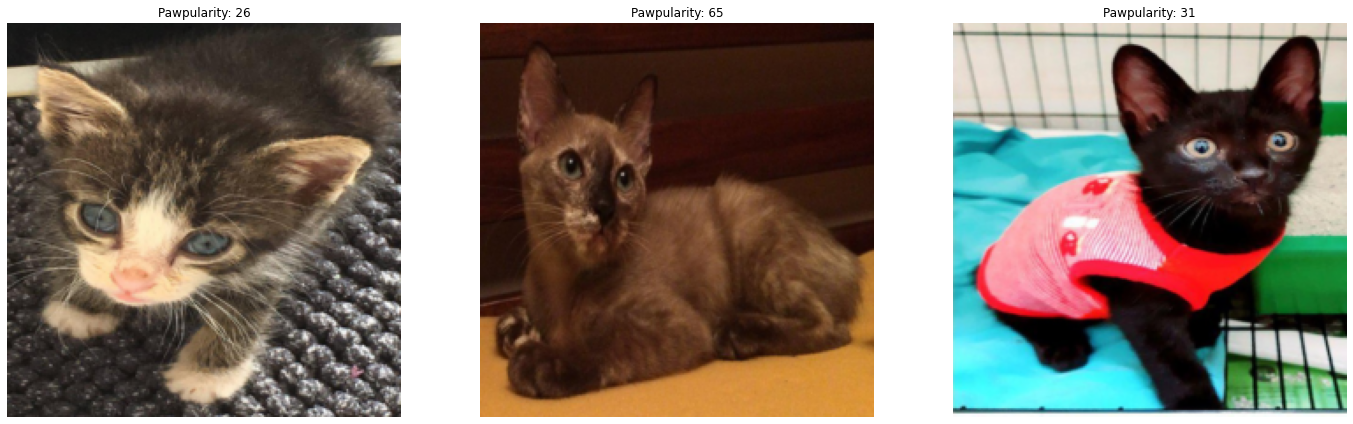

In [8]:
images, _, labels = iter(samples).next()

plt.figure(figsize=(24,24))

for idx, (img, l) in enumerate(zip(images[:3], labels[:3])):
    plt.subplot(1, 3, idx+1)
    plt.imshow(img.permute(1,2,0).cpu().numpy())
    plt.title(f'Pawpularity: {l}')
    plt.axis('off')

# Data augumentations

In [9]:
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 1.0):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Mixup cannot be applied to a single instance."

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

# Model

In [10]:
class Model(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self.criterion = eval(self.cfg.loss)()
        self.transforms = transformations()
        self.save_hyperparameters(cfg)

    def __build_model(self):
        self.cfg = Box(self.cfg)
        self.backbone = create_model(
                                     self.cfg.model.name,
                                     pretrained=True,
                                     num_classes=0,
                                     in_chans=3
                                    )
        num_features = self.backbone.num_features
        self.dropout = torch.nn.Dropout(0.1)
        self.fc1 = torch.nn.Linear(num_features + 12, 64)
        self.fc2 = torch.nn.Linear(64, self.cfg.model.output_dim)

    def __step(self, batch, mode):
        images, meta_data, labels = batch
        labels = labels.float() / 100.00
        images = self.transforms[mode](images)

        if torch.rand(1)[0] < 0.5 and mode == 'train':
            mix_images, target_a, target_b, lam = mixup(images, labels, alpha=0.5)
            logits = self.forward(mix_images, meta_data).squeeze(1)
            loss = self.criterion(logits, target_a) * lam + \
                (1 - lam) * self.criterion(logits, target_b)
        else:
            logits = self.forward(images, meta_data).squeeze(1)
            loss = self.criterion(logits, labels)

        pred = logits.sigmoid().detach().cpu() * 100
        labels = labels.detach().cpu() * 100
        
        return loss, pred, labels

    def __endepoch(self, outputs, mode):
        preds = []
        labels = []

        for out in outputs:
            p,l = out['pred'], out['labels']
            preds.append(p)  
            labels.append(l)
        preds = torch.cat(preds)
        labels = torch.cat(labels)
        metrics = torch.sqrt(((preds - labels)**2).mean())
        self.log(f'{mode}_loss', metrics, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = eval(self.cfg.optimizer.name)(
                                                  self.parameters(), 
                                                  **self.cfg.optimizer.params)
        scheduler = eval(self.cfg.scheduler.name)(
            optimizer,
            **self.cfg.scheduler.params
        )

        return [optimizer], [scheduler]

    def training_epoch_end(self, outputs):
        self.__endepoch(outputs, 'train')

    def validation_epoch_end(self, outputs):
        self.__endepoch(outputs, 'val')

    def forward(self, image, features):
        x = self.backbone(image)
        x1 = self.dropout(x) 
        x1 = torch.cat([x1, features], dim=1)
        x1 = self.fc1(x1)
        x1 = self.fc2(x1)

        #pred = torch.cat([x1, x, features], dim=1)
        return x1

    def training_step(self, batch, batch_idx):
        loss, predictions, labels = self.__step(batch, 'train')
        return {'loss': loss, 'pred': predictions, 'labels': labels}

    def validation_step(self, batch, batch_idx):
        loss, predictions, labels = self.__step(batch, 'val')
        return {'loss': loss, 'pred': predictions, 'labels': labels}

# Train

In [11]:
skf = StratifiedKFold(
    n_splits=config.n_splits, shuffle=True, random_state=666
)
print(f'Training the {config.model.name} model on {config.epoch} epochs',
      f'with batch_size {config.train_loader.batch_size}. Image size is [{config.Image_size, config.Image_size}]')

Training the swin_tiny_patch4_window7_224 model on 20 epochs with batch_size 64. Image size is [(224, 224)]


In [12]:

for fold, (train_idx, val_idx) in enumerate(skf.split(df_train["Id"], df_train["Pawpularity"])):
    train_data = df_train.iloc[train_idx].reset_index(drop=True)
    val_data = df_train.iloc[val_idx].reset_index(drop=True)
    dataloader = PetDataModule(train_data, val_data, None, config)
    model = Model(config)
    #prog_bar = TQDMProgressBar(refresh_rate=1)
    lr_monitor = callbacks.LearningRateMonitor()
    loss_chpt = callbacks.ModelCheckpoint(
        filename =  f'{fold}_fold_best_loss',#config.model.name + 'best_loss {epoch}-{val_loss:.2f}', 
        #dirpath='./checkpoints',
        monitor= 'val_loss',
        save_top_k=1,
        mode='min',
        save_last=False,
        auto_insert_metric_name=True,
        )
    logger = TensorBoardLogger(config.model.name)

    trainer = pl.Trainer(
        logger, 
        max_epochs=config.epoch, 
        callbacks=[lr_monitor, loss_chpt],
        **config.trainer
        )
    trainer.fit(model, datamodule=dataloader)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_tiny_patch4_window7_224.pth


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [13]:
# from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# path = glob.glob(f'./{config.model.name}/default/version_0/events*')[0]
# event_acc = EventAccumulator(path, size_guidance={'scalars': 0})
# event_acc.Reload()

# scalars = {}
# for tag in event_acc.Tags()['scalars']:
#     events = event_acc.Scalars(tag)
#     scalars[tag] = [event.value for event in events]

In [14]:
#scalars

In [15]:
# import seaborn as sns
# sns.set()

# plt.figure(figsize=(16, 6))
# plt.subplot(1, 2, 1)
# plt.plot(range(len(scalars['lr-AdamW'])), scalars['lr-AdamW'])
# plt.xlabel('epoch')
# plt.ylabel('lr')
# plt.title('adamw lr')

# plt.subplot(1, 2, 2)
# plt.plot(range(len(scalars['train_loss'])), scalars['train_loss'], label='train_loss')
# plt.plot(range(len(scalars['val_loss'])), scalars['val_loss'], label='val_loss')
# plt.legend()
# plt.ylabel('rmse')
# plt.xlabel('epoch')
# plt.title('train/val rmse')
# plt.show()

In [16]:
# print('best_val_loss', min(scalars['val_loss']))